## Set up

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import os
from google.colab import drive

print(tf.__version__)

2.8.0


In [2]:
!pip install -q -U keras-tuner
import keras_tuner as kt

     |████████████████████████████████| 133 kB 18.9 MB/s 


In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
data_folder = '/content/drive/MyDrive/Colab Notebooks/DLinMIA/Project2/'

## Load and explore the dataset

Load the datset and print its information.  
Trainng size: 2520   
Testing size: 372  
Number of classes: 3  
Image size: 300 * 300 * 3  

In [4]:
(train_raw, test_raw), info = tfds.load(name='rock_paper_scissors', 
                                        with_info=True, 
                                        as_supervised=True,
                                        split=[tfds.Split.TRAIN, tfds.Split.TEST])

print('The size of training dataset is: ', len(train_raw))
print('The size of testing dataset is: ', len(test_raw))
print('Image size: ', info.features['image'].shape)

print('\nLabel classes number: ', info.features['label'].num_classes)
print('Label name: ', info.features['label'].names)

print('\ndataset info: ', info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incompletePY0OWI/rock_paper_scissors-train.tfrecord


  0%|          | 0/2520 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incompletePY0OWI/rock_paper_scissors-test.tfrecord


  0%|          | 0/372 [00:00<?, ? examples/s]

Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.
The size of training dataset is:  2520
The size of testing dataset is:  372
Image size:  (300, 300, 3)

Label classes number:  3
Label name:  ['rock', 'paper', 'scissors']

dataset info:  tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    version=3.0.0,
    description='Images of hands playing rock, paper, scissor game.',
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    total_num_examples=2892,
    splits={
        'test': 372,
        'train': 2520,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    

In [5]:
get_label = info.features['label'].int2str
print(get_label(0))
print(get_label(1))
print(get_label(2))

rock
paper
scissors


Dataset visualization

In [6]:
def preview(dataset):
  idx = 1
  plt.figure(figsize=(10,10))
  for feature in dataset.take(25):
      (img, label) = feature
      plt.subplot(5,5,idx)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(img)
      plt.xlabel(get_label(label))
      idx+=1
  plt.show()

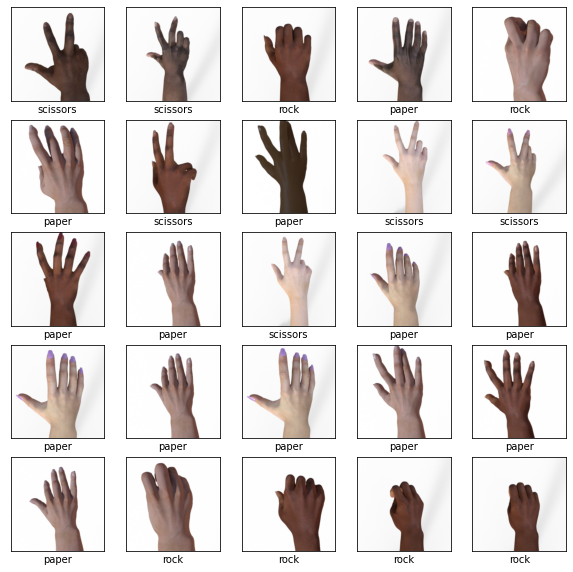

In [7]:
preview(train_raw)

In [8]:
(image_1, label_1) = list(train_raw.take(1))[0]
print('Label:', label_1.numpy(), '\n')
print('Image shape:', image_1.numpy().shape, '\n')

Label: 2 

Image shape: (300, 300, 3) 



## Data augmentation

### Preprocess

Convert the dtype from int into float for future process. Also, rescale the pixel value in between 0 and 1.

In [9]:
def preprocess(img, label):
  img = tf.cast(img, tf.float32)
  img = img/255.0
  img = tf.image.resize(img, [200,200])
  return img, label

In [10]:
train = train_raw.map(preprocess)

In [11]:
(testi, testl) = list(train.take(1))[0]

In [12]:
print("Min and max pixel values:", testi.numpy().min(), testi.numpy().max())
print("Imgae size: ", testi.numpy().shape)

Min and max pixel values: 0.05147059 0.99828434
Imgae size:  (200, 200, 3)




---



In [13]:
test = test_raw.map(preprocess)

### Data augmentation

In [14]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomContrast(0.2),
  tf.keras.layers.RandomZoom(0.25, 0.25),
  tf.keras.layers.RandomRotation(0.2),
])

In [15]:
aug_train = train.map(lambda x, y: (data_augmentation(x, training=True), y))

In [19]:
# aug_test = test.map(lambda x, y: (data_augmentation(x, training=True), y))

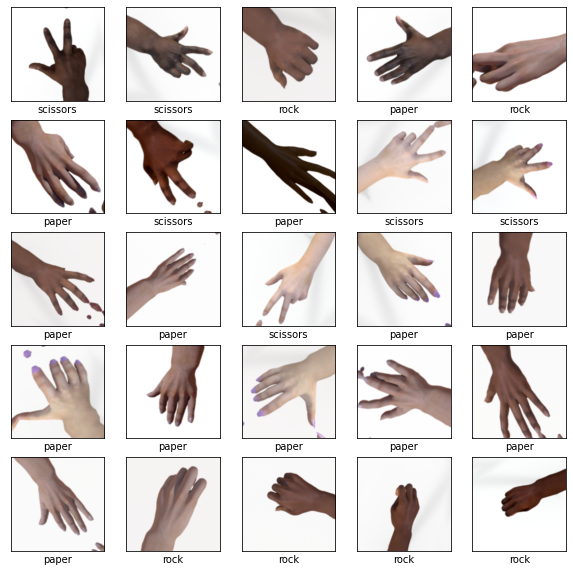

In [16]:
preview(aug_train)

## Shuffle and batching

In [17]:
# BATCH_SIZE = 32
BATCH_SIZE = 64
NUM_TRAIN = 2520 
aug_train = aug_train.shuffle(buffer_size=NUM_TRAIN, reshuffle_each_iteration=True)
aug_train = aug_train.batch(BATCH_SIZE)
# prefetch
aug_train = aug_train.prefetch(buffer_size=tf.data.AUTOTUNE)

# Test set batching
test = test.batch(BATCH_SIZE)

## Model Hypertune

### For builder 1 (Used only to find the right direction for optimizing hyperparameters)

In [ ]:
def model_builder(hp):
  model = tf.keras.models.Sequential()

  # 1st convolution.
  model.add(tf.keras.layers.Convolution2D(
      input_shape=(200,200,3),
      filters=hp.Int('conv1_filter', min_value=8, max_value=16, step=8),
      kernel_size=3,
      activation=tf.keras.activations.relu
  ))
  model.add(tf.keras.layers.AveragePooling2D(
      pool_size=(2, 2),
      strides=(2, 2),
      padding='same'
  ))
  model.add(tf.keras.layers.Dropout(
      hp.Float('dropout1', min_value=0, max_value=0.5, step=0.25)
  ))

  # 2nd convolution.
  model.add(tf.keras.layers.Convolution2D(
      filters=hp.Int('conv2_filter', min_value=16, max_value=64, step=16),
      kernel_size=3,
      activation=tf.keras.activations.relu
  ))
  model.add(tf.keras.layers.AveragePooling2D(
      pool_size=(2, 2),
      strides=(2, 2)
  ))
  model.add(tf.keras.layers.Dropout(
      hp.Float('dropout2', min_value=0, max_value=0.5, step=0.25)
  ))

  # 3rd convolution.
  model.add(tf.keras.layers.Convolution2D(
      filters=hp.Int('conv3_filter', min_value=64, max_value=128, step=32),
      kernel_size=3,
      activation=tf.keras.activations.relu
  ))

  # 4th convolution.
  model.add(tf.keras.layers.Convolution2D(
      filters=hp.Int('conv4_filter', min_value=64, max_value=128, step=32),
      kernel_size=3,
      activation=tf.keras.activations.relu
  ))

  # Flatten the results
  model.add(tf.keras.layers.Flatten())

  # 1st dense layer.
  model.add(tf.keras.layers.Dense(
      units=hp.Int('unit1', min_value=256, max_value=512, step=128),
      activation=tf.keras.activations.relu
  ))

  # 2nd dense layer
  model.add(tf.keras.layers.Dense(
      units=hp.Int('unit2', min_value=128, max_value=256, step=128),
      activation=tf.keras.activations.relu
  ))

  # Output layer.
  model.add(tf.keras.layers.Dense(
      units=3,
      activation=tf.keras.activations.softmax
  ))

  model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-3, 1e-4])),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
  return model

---

Initiate tuner and perform hypertuning

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=5,
                     directory='/content/drive/MyDrive/Colab Notebooks',
                     project_name='RockPaperScissor_model')

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
tuner.search(aug_train, epochs=50, validation_data=aug_test, callbacks=[stop_early])

Trial 10 Complete [00h 03m 07s]
val_accuracy: 0.5752688050270081

Best val_accuracy So Far: 0.7177419066429138
Total elapsed time: 00h 19m 18s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Find the optimal hyperparameters

In [ ]:
# Get the optimal hyperparameters
best_hps_model=tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
best_hps_model.values

{'conv1_filter': 8,
 'conv2_filter': 48,
 'conv3_filter': 64,
 'conv4_filter': 96,
 'dropout1': 0.0,
 'dropout2': 0.25,
 'learning_rate': 0.001,
 'tuner/bracket': 1,
 'tuner/epochs': 5,
 'tuner/initial_epoch': 2,
 'tuner/round': 1,
 'tuner/trial_id': '0002',
 'unit1': 384,
 'unit2': 128}

---

### For builder 2 (This one makes overfitting)

In [21]:
def model_builder2(hp):
  model = tf.keras.models.Sequential()

  # 1st convolution.
  model.add(tf.keras.layers.Convolution2D(
      input_shape=(200,200,3),
      filters=hp.Int('conv1_filter', min_value=8, max_value=32, step=8),
      kernel_size=3,
      activation=tf.keras.activations.relu
  ))
  model.add(tf.keras.layers.AveragePooling2D(
      pool_size=(2, 2),
      strides=(2, 2),
      padding='same'
  ))
  model.add(tf.keras.layers.Dropout(
      hp.Float('dropout1', min_value=0, max_value=0.5, step=0.25)
  ))

  # 2nd convolution.
  model.add(tf.keras.layers.Convolution2D(
      filters=hp.Int('conv2_filter', min_value=32, max_value=128, step=16),
      kernel_size=3,
      activation=tf.keras.activations.relu
  ))
  model.add(tf.keras.layers.AveragePooling2D(
      pool_size=(2, 2),
      strides=(2, 2)
  ))
  model.add(tf.keras.layers.Dropout(
      hp.Float('dropout2', min_value=0, max_value=0.5, step=0.25)
  ))

  # 3rd convolution.
  model.add(tf.keras.layers.Convolution2D(
      filters=hp.Int('conv3_filter', min_value=96, max_value=160, step=32),
      kernel_size=3,
      activation=tf.keras.activations.relu
  ))

  # 4th convolution.
  model.add(tf.keras.layers.Convolution2D(
      filters=hp.Int('conv4_filter', min_value=96, max_value=256, step=32),
      kernel_size=3,
      activation=tf.keras.activations.relu
  ))

  # Flatten the results
  model.add(tf.keras.layers.Flatten())

  # 1st dense layer.
  model.add(tf.keras.layers.Dense(
      units=hp.Int('unit1', min_value=256, max_value=512, step=128),
      activation=tf.keras.activations.relu
  ))

  # 2nd dense layer
  model.add(tf.keras.layers.Dense(
      units=hp.Int('unit2', min_value=128, max_value=256, step=128),
      activation=tf.keras.activations.relu
  ))

  # Output layer.
  model.add(tf.keras.layers.Dense(
      units=3,
      activation=tf.keras.activations.softmax
  ))

  model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-3, 1e-4])),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
  return model

In [ ]:
tuner = kt.Hyperband(model_builder2,
                     objective='val_accuracy',
                     max_epochs=5,
                     directory=data_folder+'',
                     project_name='RockPaperScissor_model_2')

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
tuner.search(aug_train, epochs=100, validation_data=aug_test, callbacks=[stop_early])

Trial 10 Complete [00h 06m 03s]
val_accuracy: 0.6962365508079529

Best val_accuracy So Far: 0.8333333134651184
Total elapsed time: 00h 23m 50s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Here's the parameters of builder 2

In [ ]:
best_hps_model_2=tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
best_hps_model_2.values

{'conv1_filter': 16,
 'conv2_filter': 96,
 'conv3_filter': 128,
 'conv4_filter': 128,
 'dropout1': 0.0,
 'dropout2': 0.25,
 'learning_rate': 0.0001,
 'tuner/bracket': 0,
 'tuner/epochs': 5,
 'tuner/initial_epoch': 0,
 'tuner/round': 0,
 'unit1': 256,
 'unit2': 128}

Compare the results of builder 1 and builder 2, we choose the builder 2 due to its higher validation accuracy.

#### Builder 2 model

In [ ]:
best_model = tuner.hypermodel.build(best_hps_model_2)
history = best_model.fit(aug_train, epochs=30, validation_data = aug_test)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


79/79 [==============================] - 54s 124ms/step - loss: 1.0995 - accuracy: 0.3667 - val_loss: 1.0623 - val_accuracy: 0.4624
Epoch 2/30
79/79 [==============================] - 34s 120ms/step - loss: 0.9216 - accuracy: 0.5504 - val_loss: 0.8388 - val_accuracy: 0.6505
Epoch 3/30
79/79 [==============================] - 34s 120ms/step - loss: 0.6435 - accuracy: 0.7306 - val_loss: 0.7033 - val_accuracy: 0.6694
Epoch 4/30
79/79 [==============================] - 35s 132ms/step - loss: 0.4790 - accuracy: 0.8075 - val_loss: 0.6652 - val_accuracy: 0.7097
Epoch 5/30
79/79 [==============================] - 40s 120ms/step - loss: 0.3831 - accuracy: 0.8492 - val_loss: 0.6846 - val_accuracy: 0.7204
Epoch 6/30
79/79 [==============================] - 34s 119ms/step - loss: 0.3282 - accuracy: 0.8790 - val_loss: 0.6010 - val_accuracy: 0.7581
Epoch 7/30
79/79 [==============================] - 34s 121ms/step - loss: 0.2675 - accuracy: 0.8984 - val_loss: 0.4946 - val_accuracy: 0.7688
Epoch 8/30

In [ ]:
my_model = tuner.hypermodel.build(best_hps_model_2)

# Retrain the model
my_model.fit(aug_train, epochs=best_epoch, validation_data=aug_test)

Epoch 1/25


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


79/79 [==============================] - 35s 121ms/step - loss: 1.1013 - accuracy: 0.3615 - val_loss: 1.0889 - val_accuracy: 0.5161
Epoch 2/25
79/79 [==============================] - 38s 139ms/step - loss: 0.9641 - accuracy: 0.5302 - val_loss: 0.9582 - val_accuracy: 0.5269
Epoch 3/25
79/79 [==============================] - 32s 119ms/step - loss: 0.7181 - accuracy: 0.6885 - val_loss: 0.7425 - val_accuracy: 0.6801
Epoch 4/25
79/79 [==============================] - 33s 120ms/step - loss: 0.5380 - accuracy: 0.7865 - val_loss: 0.6122 - val_accuracy: 0.7258
Epoch 5/25
79/79 [==============================] - 33s 120ms/step - loss: 0.4247 - accuracy: 0.8325 - val_loss: 0.5445 - val_accuracy: 0.7527
Epoch 6/25
79/79 [==============================] - 38s 133ms/step - loss: 0.3506 - accuracy: 0.8722 - val_loss: 0.4972 - val_accuracy: 0.7769
Epoch 7/25
79/79 [==============================] - 33s 120ms/step - loss: 0.3014 - accuracy: 0.8897 - val_loss: 0.6457 - val_accuracy: 0.7177
Epoch 8/25

In [ ]:
my_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 198, 198, 16)      448       
                                                                 
 average_pooling2d_6 (Averag  (None, 99, 99, 16)       0         
 ePooling2D)                                                     
                                                                 
 dropout_6 (Dropout)         (None, 99, 99, 16)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 97, 97, 96)        13920     
                                                                 
 average_pooling2d_7 (Averag  (None, 48, 48, 96)       0         
 ePooling2D)                                                     
                                                                 
 dropout_7 (Dropout)         (None, 48, 48, 96)       

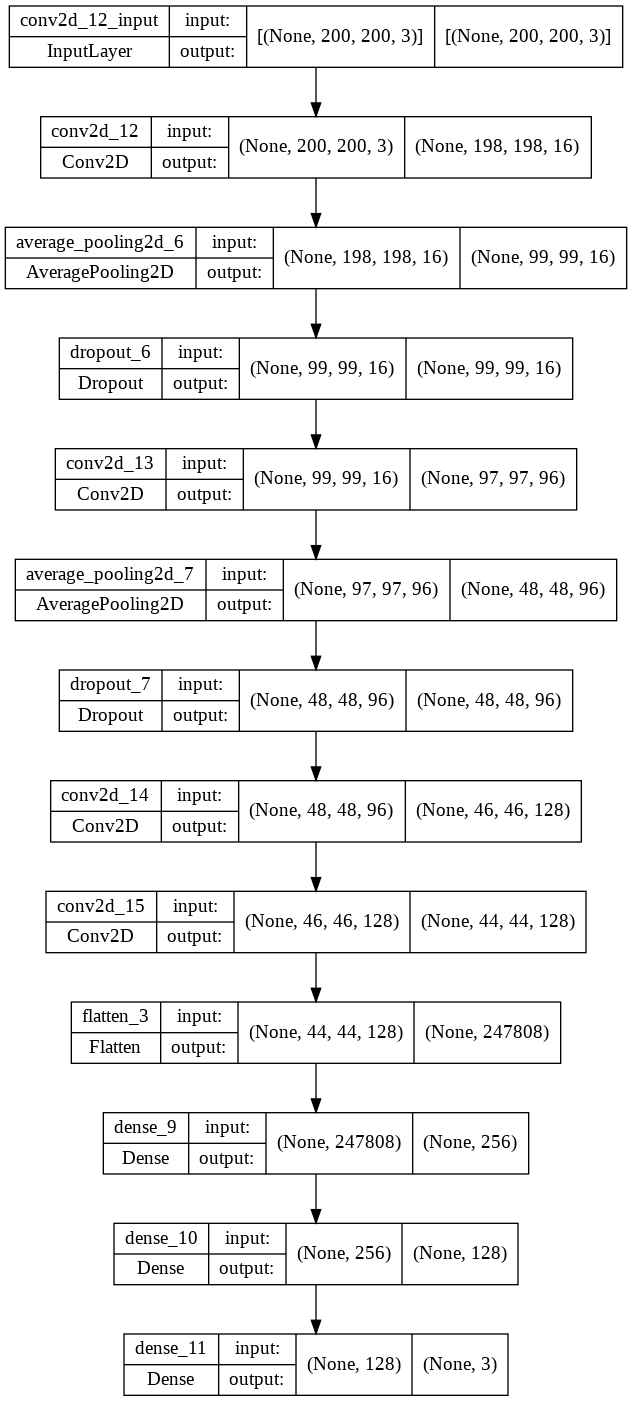

In [ ]:
tf.keras.utils.plot_model(
    my_model,
    show_shapes=True,
    show_layer_names=True,
)

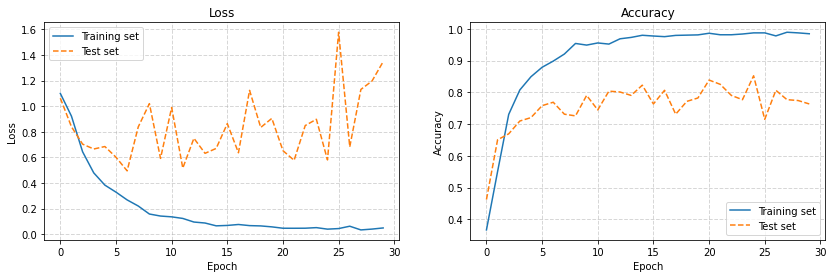

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(loss, label='Training set')
plt.plot(val_loss, label='Test set', linestyle='--')
plt.legend()
plt.grid(linestyle='--', linewidth=1, alpha=0.5)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(accuracy, label='Training set')
plt.plot(val_accuracy, label='Test set', linestyle='--')
plt.legend()
plt.grid(linestyle='--', linewidth=1, alpha=0.5)

plt.show()

In [ ]:
my_model.save('/content/drive/MyDrive/Colab Notebooks/my_model') 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/my_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/my_model/assets


### Builder 2 improvement results

We noticed that the original builder 2 has serious problem on overfitting, so we makek some improvements. The improvements include making the batch size to 64(original is 32), feed the test dataset(original is the test dataset being data augmentation) as validation dataset.

In [22]:
tuner = kt.Hyperband(model_builder2,
                     objective='val_accuracy',
                     max_epochs=5,
                     directory=data_folder,
                     project_name='RockPaperScissor_model_noaugtest')

INFO:tensorflow:Reloading Oracle from existing project /content/drive/MyDrive/Colab Notebooks/DLinMIA/Project2/RockPaperScissor_model_noaugtest/oracle.json


INFO:tensorflow:Reloading Oracle from existing project /content/drive/MyDrive/Colab Notebooks/DLinMIA/Project2/RockPaperScissor_model_noaugtest/oracle.json


INFO:tensorflow:Reloading Tuner from /content/drive/MyDrive/Colab Notebooks/DLinMIA/Project2/RockPaperScissor_model_noaugtest/tuner0.json


INFO:tensorflow:Reloading Tuner from /content/drive/MyDrive/Colab Notebooks/DLinMIA/Project2/RockPaperScissor_model_noaugtest/tuner0.json


In [ ]:
tuner.search(aug_train, epochs=80, validation_data=test, callbacks=[stop_early])

In [23]:
best_hps_model_2_noaugtest=tuner.get_best_hyperparameters(num_trials=1)[0]

In [24]:
best_hps_model_2_noaugtest.values

{'conv1_filter': 16,
 'conv2_filter': 96,
 'conv3_filter': 160,
 'conv4_filter': 96,
 'dropout1': 0.0,
 'dropout2': 0.0,
 'learning_rate': 0.0001,
 'tuner/bracket': 0,
 'tuner/epochs': 5,
 'tuner/initial_epoch': 0,
 'tuner/round': 0,
 'unit1': 512,
 'unit2': 256}

### Improved model

In [25]:
improved_model = tuner.hypermodel.build(best_hps_model_2_noaugtest)
history = improved_model.fit(aug_train, epochs=50, validation_data = test)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


40/40 [==============================] - 40s 177ms/step - loss: 1.1095 - accuracy: 0.3651 - val_loss: 1.0703 - val_accuracy: 0.5591
Epoch 2/50
40/40 [==============================] - 31s 169ms/step - loss: 0.9857 - accuracy: 0.5345 - val_loss: 0.8654 - val_accuracy: 0.6075
Epoch 3/50
40/40 [==============================] - 34s 161ms/step - loss: 0.7687 - accuracy: 0.6587 - val_loss: 0.6545 - val_accuracy: 0.6747
Epoch 4/50
40/40 [==============================] - 31s 164ms/step - loss: 0.5742 - accuracy: 0.7694 - val_loss: 0.6718 - val_accuracy: 0.7473
Epoch 5/50
40/40 [==============================] - 30s 145ms/step - loss: 0.4682 - accuracy: 0.8179 - val_loss: 1.0057 - val_accuracy: 0.6102
Epoch 6/50
40/40 [==============================] - 32s 156ms/step - loss: 0.3871 - accuracy: 0.8607 - val_loss: 0.6229 - val_accuracy: 0.7769
Epoch 7/50
40/40 [==============================] - 30s 145ms/step - loss: 0.2978 - accuracy: 0.8960 - val_loss: 0.3706 - val_accuracy: 0.8011
Epoch 8/50

In [ ]:
print('Best epoch: %d' % (best_epoch,))

Best epoch: 29


In [ ]:
my_improved_model = tuner.hypermodel.build(best_hps_model_2_noaugtest)

# Retrain the model
my_improved_model.fit(aug_train, epochs=best_epoch, validation_data=test)

Epoch 1/29


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


40/40 [==============================] - 28s 150ms/step - loss: 1.1132 - accuracy: 0.3857 - val_loss: 1.0582 - val_accuracy: 0.5699
Epoch 2/29
40/40 [==============================] - 28s 148ms/step - loss: 0.9598 - accuracy: 0.5377 - val_loss: 0.9738 - val_accuracy: 0.5000
Epoch 3/29
40/40 [==============================] - 28s 147ms/step - loss: 0.7643 - accuracy: 0.6552 - val_loss: 0.7192 - val_accuracy: 0.7419
Epoch 4/29
40/40 [==============================] - 28s 147ms/step - loss: 0.5884 - accuracy: 0.7500 - val_loss: 0.5032 - val_accuracy: 0.8468
Epoch 5/29
40/40 [==============================] - 28s 149ms/step - loss: 0.4675 - accuracy: 0.8175 - val_loss: 0.4718 - val_accuracy: 0.8065
Epoch 6/29
40/40 [==============================] - 28s 148ms/step - loss: 0.3875 - accuracy: 0.8516 - val_loss: 0.4537 - val_accuracy: 0.7688
Epoch 7/29
40/40 [==============================] - 28s 150ms/step - loss: 0.3368 - accuracy: 0.8746 - val_loss: 0.2946 - val_accuracy: 0.8871
Epoch 8/29

In [ ]:
my_improved_model.save(data_folder+'my_improved_model') 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/my_improved_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/my_improved_model/assets


In [ ]:
validation_loss, validation_acc = my_improved_model.evaluate(test, verbose=2)

print('\nValidation loss: {}\nValidation accuracy: {}'.format(validation_loss, validation_acc))

6/6 - 2s - loss: 0.3321 - accuracy: 0.9032 - 2s/epoch - 309ms/step

Validation loss: 0.33212435245513916
Validation accuracy: 0.9032257795333862


In [29]:
# Load model
my_improved_model = tf.keras.models.load_model(data_folder+'my_improved_model')

In [30]:
my_improved_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 198, 198, 16)      448       
                                                                 
 average_pooling2d_4 (Averag  (None, 99, 99, 16)       0         
 ePooling2D)                                                     
                                                                 
 dropout_4 (Dropout)         (None, 99, 99, 16)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 97, 97, 96)        13920     
                                                                 
 average_pooling2d_5 (Averag  (None, 48, 48, 96)       0         
 ePooling2D)                                                     
                                                                 
 dropout_5 (Dropout)         (None, 48, 48, 96)       

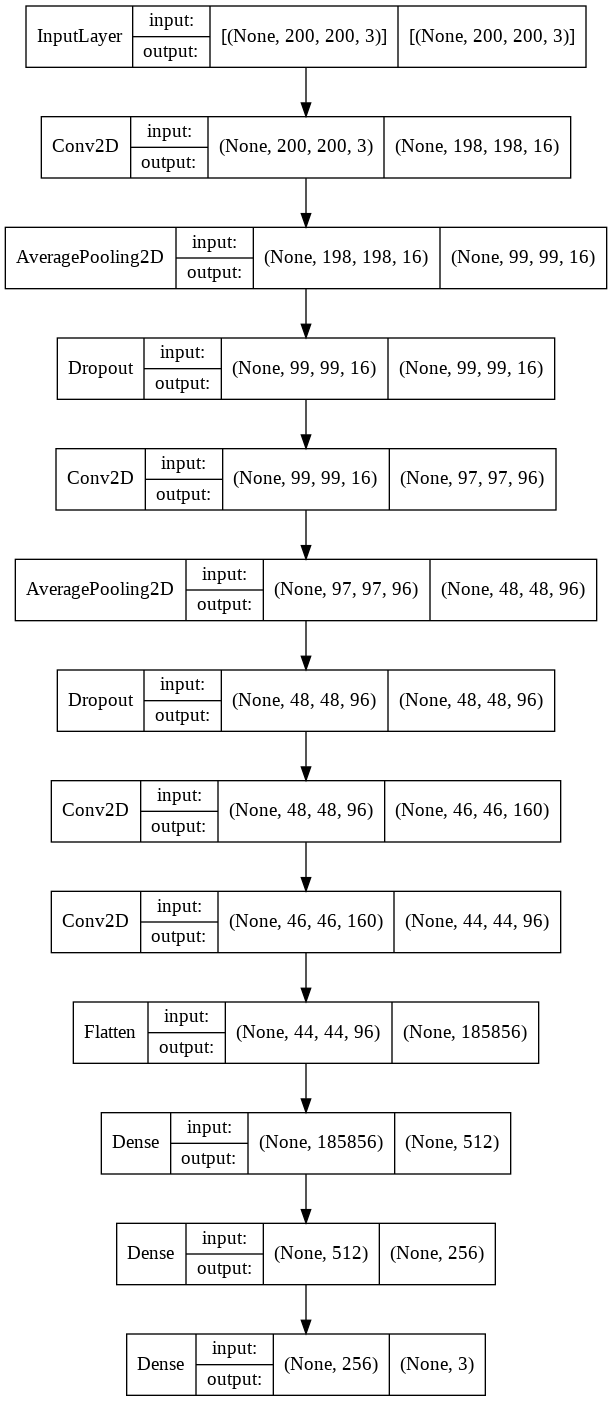

In [31]:
tf.keras.utils.plot_model(
    my_improved_model,
    show_shapes=True,
    show_layer_names=False
)

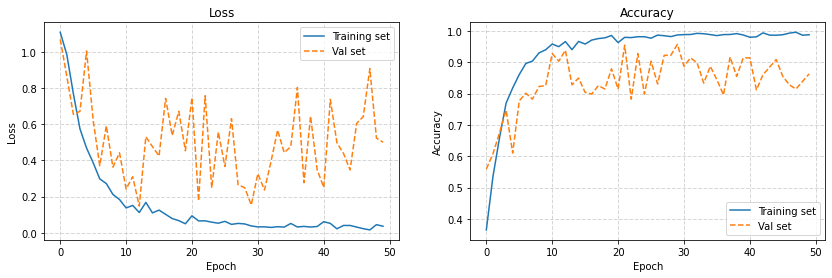

In [26]:
loss = history.history['loss']
val_loss = history.history['val_loss']

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(loss, label='Training set')
plt.plot(val_loss, label='Val set', linestyle='--')
plt.legend()
plt.grid(linestyle='--', linewidth=1, alpha=0.5)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(accuracy, label='Training set')
plt.plot(val_accuracy, label='Val set', linestyle='--')
plt.legend()
plt.grid(linestyle='--', linewidth=1, alpha=0.5)

plt.show()

## Prediction

In [ ]:
predictions = my_model.predict(test)

In [ ]:
"""Graph this to look at the full set of 3 class predictions."""
def plot_image(i, predictions_array, data):
  (img, true_label) = list(data)[0]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label.numpy():
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(get_label(predicted_label),
                                100*np.max(predictions_array),
                                get_label(true_label)),
                                color=color)

def plot_value_array(i, predictions_array, data):
  (img, true_label) = list(data)[0]
  
  plt.grid(False)
  plt.xticks(range(3))
  plt.yticks([])
  thisplot = plt.bar(range(3), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label.numpy()].set_color('blue')

err


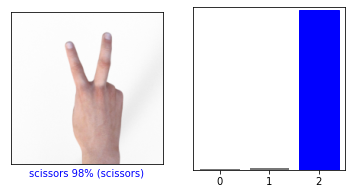

In [ ]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test.take(1))
plt.subplot(1,2,2)
plot_value_array(i, predictions[i], test.take(1))
plt.show()

### Prediction on real test image

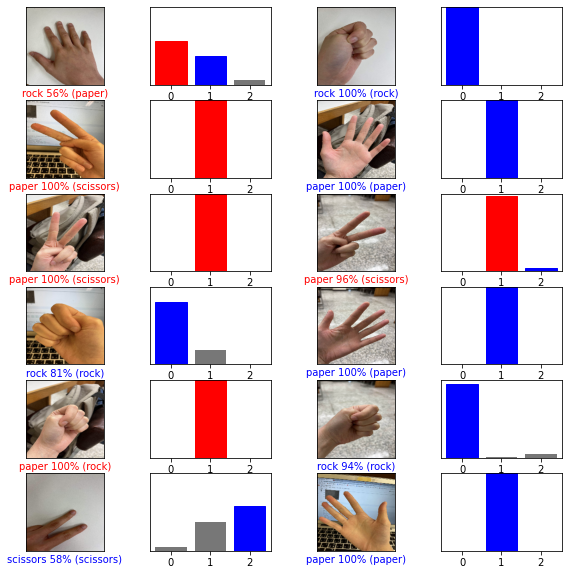

In [33]:
import cv2
image_folder = data_folder+'real_test_images/'
self_test = np.array([], dtype=float).reshape(200, 200, 0)
index=0
plt.figure(figsize=(10,10))
for file in os.listdir(image_folder):
  if file.endswith(".jpg"):
    image = cv2.imread(image_folder+file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image/255.0
    image = cv2.resize(image, dsize=(200,200), interpolation=cv2.INTER_CUBIC)
    true_label = (file.split('_')[1]).split('.')[0] #extract the true label from file name

    data = np.expand_dims(image, axis=0) #expand the dimension to feed into the prediction model
    pre_array = my_improved_model.predict(data) #make the prediction
    pre_label = get_label(np.argmax(pre_array)) #get the predicted label
    plt.subplot(6,4,index+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image)
    if pre_label == true_label:
      color = 'blue'
    else:
      color = 'red'
    plt.xlabel("{} {:2.0f}% ({})".format(pre_label,
                                  100*np.max(pre_array),
                                  true_label),
                                  color=color)
    index=index+1
    # print(pre_array[])
    plt.subplot(6,4,index+1)
    plt.grid(False)
    plt.xticks(range(3))
    plt.yticks([])
    thisplot = plt.bar(range(3), pre_array[0], color="#777777")
    plt.ylim([0, 1])
    thisplot[np.argmax(pre_array[0])].set_color('red')
    true_label_num = ['rock', 'paper', 'scissors'].index(true_label)
    thisplot[true_label_num].set_color('blue')
    index=index+1
  else:
    continue